**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [4]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.Y_train = y
        self.class_num = np.unique(y).shape[0]
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            distances = cdist(X, self.X_train, metric=self.metric)
            indexes = np.argpartition(distances, self.n_neighbors,
                                      axis=1)[::, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            distances, indexes = self.tree.query(X, k=self.n_neighbors)
        return (np.apply_along_axis(np.bincount, 1, self.Y_train[indexes],
                minlength=self.class_num)) / self.n_neighbors

    def score(self, X, y):
        predicts = self.predict(X)
        return np.mean(y == predicts)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [5]:
iris = datasets.load_iris()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [7]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [8]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [9]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [10]:
%time clf.fit(X_train, y_train)

CPU times: user 980 µs, sys: 0 ns, total: 980 µs
Wall time: 1.18 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [11]:
%time my_clf.fit(X_train, y_train)

CPU times: user 107 µs, sys: 20 µs, total: 127 µs
Wall time: 132 µs


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [12]:
%time clf.predict(X_test)

CPU times: user 4.75 ms, sys: 89 µs, total: 4.84 ms
Wall time: 4 ms


array([0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 0, 2, 2, 1, 0])

In [13]:
%time my_clf.predict(X_test)

CPU times: user 1.33 ms, sys: 74 µs, total: 1.41 ms
Wall time: 1.02 ms


array([0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 0, 2, 2, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 2.23 ms, sys: 187 µs, total: 2.42 ms
Wall time: 3.57 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 484 µs, sys: 0 ns, total: 484 µs
Wall time: 848 µs


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=2)

In [18]:
%time clf.predict(X_test)

CPU times: user 2.51 ms, sys: 1.06 ms, total: 3.57 ms
Wall time: 2.91 ms


array([1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 439 µs, sys: 678 µs, total: 1.12 ms
Wall time: 848 µs


array([1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2])

In [20]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [23]:
vectorizer = CountVectorizer(max_features=1000)

In [24]:
X = vectorizer.fit_transform(data).toarray()

In [26]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [25]:
def optimal_n(X, y, classifier, nsplit=3,
             first_k=1, last_k=10, draw_graph=False):
    results = [(sum(classifier(k)
                    .fit(X[train_index], y[train_index])
                    .score(X[test_index], y[test_index])
                    for train_index, test_index in KFold(nsplit).split(X)) / nsplit)
                        for k in range(first_k, last_k + 1)]
    if draw_graph:
        print(results)
        plt.plot(range(first_k, last_k + 1), results)
    print("Оптимальное число соседей:", results.index(max(results)) + 1,
          "с качаством на кросс валидации:", max(results))
    return results.index(max(results)) + 1

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

[0.13010379766555788, 0.13531863838924785, 0.1370862348414567, 0.1378818032239677, 0.139649657452612, 0.14283155603511347, 0.14168255272535776, 0.1416823652515865, 0.14150536657730728, 0.14106370180646913, 0.14238944601406858]
Оптимальное число соседей: 6 с качаством на кросс валидации: 0.14283155603511347


6

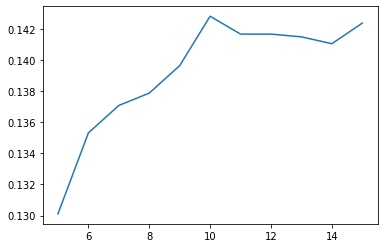

In [ ]:
optimal_n(
        X, target, 
        lambda k: MyKNeighborsClassifier(n_neighbors=k, algorithm='brute'),
        3, 5, 15, draw_graph=True)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [27]:
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)
X = X.toarray()

In [ ]:
text_clf = lambda k: Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MyKNeighborsClassifier(
        n_neighbors=k, 
        algorithm='brute',
        metric='cosine'))
])

[0.4270822407127603, 0.4292034126975423]
Оптимальное число соседей: 2 с качаством на кросс валидации: 0.4292034126975423


2

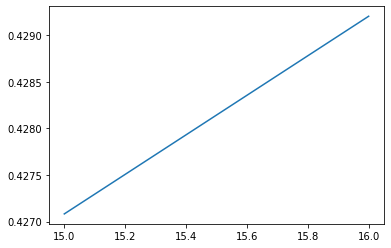

In [30]:
optimal_n(X, target, 
          lambda k: MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='cosine'),
          3, 15, 16, draw_graph=True)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [28]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [29]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [30]:
vectorizer = CountVectorizer(max_features=10000)

In [31]:
vectorizer.fit(data + data_test)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [32]:
X = vectorizer.transform(data).toarray()
X_test = vectorizer.transform(data_test).toarray()
tfidf = TfidfTransformer()
tfidf.fit(np.vstack((X, X_test)))
X = tfidf.transform(X).toarray()
X_test = tfidf.transform(X_test).toarray()

In [33]:
cls = MyKNeighborsClassifier(
        n_neighbors=20, 
        algorithm='brute',
        metric='cosine')

In [34]:
cls.fit(X, target).score(X_test, target_test)

0.5265533722782794

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.